## Multinomial Logistic Regression/Softmax Regression

**Implementation of Multinomial Logistic Regression using Pytorch**


In [1]:
import pandas as pd
import torch
from torch.autograd import grad
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('/content/iris_softmax.data', index_col=None, header=None)
df.columns = ['x1', 'x2', 'x3', 'x4', 'y']

d = {'Iris-versicolor': 1,
     'Iris-virginica': 2,
     'Iris-setosa': 0,
}

df['y'] = df['y'].map(d)

In [3]:
df

,x1,x2,x3,x4,y
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [4]:
X = torch.tensor(df[['x2', 'x4']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.int)

In [5]:
torch.manual_seed(120)

shuffle_idx=torch.randperm(X.shape[0])

X=X[shuffle_idx]
y=y[shuffle_idx]

percent70=int(0.7*X.shape[0])

X_train,X_test=X[:percent70],X[percent70:]
y_train,y_test=y[:percent70],y[percent70:]

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

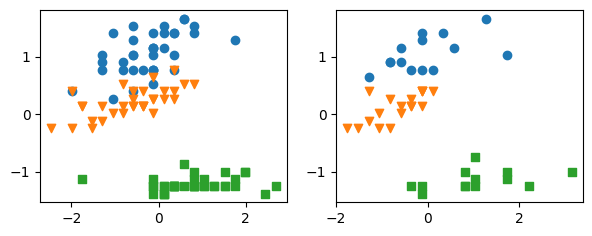

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(X_train[y_train == 2, 0], X_train[y_train == 2, 1])
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], marker='v')
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], marker='s')
ax[1].scatter(X_test[y_test == 2, 0], X_test[y_test == 2, 1])
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], marker='v')
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], marker='s')
plt.show()

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 1. Softmax Regression SemiAutomated


In [8]:
class SoftmaxRegression01():
  def __init__(self,num_features,num_classes):
    self.num_features=num_features
    self.weights=torch.zeros(num_features,num_classes,dtype=torch.float,device=device,requires_grad=True)
    self.bias=torch.zeros(num_classes,dtype=torch.float,device=device,requires_grad=True)

  def forward(self,X):
    logits=torch.matmul(X,self.weights)+self.bias
    return logits

  def train(self,X,y,num_epochs,lr=0.01,batch_size=10):
    loss_arr=[]
    torch.manual_seed(123)

    for epoch in range(num_epochs):
      shuffle_idx=torch.randperm(X.shape[0])
      X=X[shuffle_idx]
      y=y[shuffle_idx]

      batch_indices=torch.split(shuffle_idx,batch_size)

      for batch_idx in batch_indices:
        y_hat=self.forward(X[batch_idx])
        loss=F.cross_entropy(y_hat,y[batch_idx].type(torch.int64))
        grad_w=grad(loss,self.weights,retain_graph=True)[0]
        grad_b=grad(loss,self.bias)[0]
        self.weights=self.weights-lr*grad_w
        self.bias=self.bias-lr*grad_b

      with torch.no_grad():
        y_preds=self.forward(X)
        epoch_loss=F.cross_entropy(y_preds,y.type(torch.int64))

        print(f"Epoch {epoch} loss {epoch_loss}")
        loss_arr.append(epoch_loss)
    return loss_arr


In [9]:
softmax_regr01=SoftmaxRegression01(num_features=X.shape[1],num_classes=len(torch.unique(y_train)))
loss=softmax_regr01.train(X_train,y_train,50)

Epoch 0 loss 1.0514488220214844
Epoch 1 loss 1.0101319551467896
Epoch 2 loss 0.9717589020729065
Epoch 3 loss 0.9361893534660339
Epoch 4 loss 0.9043244123458862
Epoch 5 loss 0.8749634027481079
Epoch 6 loss 0.8481345772743225
Epoch 7 loss 0.8229734897613525
Epoch 8 loss 0.8001627326011658
Epoch 9 loss 0.7794102430343628
Epoch 10 loss 0.7604812383651733
Epoch 11 loss 0.7429279685020447
Epoch 12 loss 0.7264118790626526
Epoch 13 loss 0.7118656039237976
Epoch 14 loss 0.6982561945915222
Epoch 15 loss 0.6849701404571533
Epoch 16 loss 0.6727284789085388
Epoch 17 loss 0.661255419254303
Epoch 18 loss 0.6505182385444641
Epoch 19 loss 0.6405062675476074
Epoch 20 loss 0.6309293508529663
Epoch 21 loss 0.6222454309463501
Epoch 22 loss 0.6139550805091858
Epoch 23 loss 0.6059842109680176
Epoch 24 loss 0.5983920693397522
Epoch 25 loss 0.5912732481956482
Epoch 26 loss 0.5843373537063599
Epoch 27 loss 0.5777280926704407
Epoch 28 loss 0.5716201663017273
Epoch 29 loss 0.5656223297119141
Epoch 30 loss 0.56003

In [10]:
print('\nModel parameters:')
print('  Weights: %s' % softmax_regr01.weights)
print('  Bias: %s' % softmax_regr01.bias)


Model parameters:
  Weights: tensor([[ 0.5603, -0.4928, -0.0675],
        [-1.0902,  0.0771,  1.0131]], grad_fn=<SubBackward0>)
  Bias: tensor([-0.0440,  0.0509, -0.0069], grad_fn=<SubBackward0>)


In [11]:
y_preds=softmax_regr01.forward(X_test)
y_preds=torch.argmax(y_preds,dim=1)
accuracy=torch.sum(y_preds==y_test)/len(y_preds)
print(f"Accuracy {accuracy*100}")

Accuracy 86.66666412353516


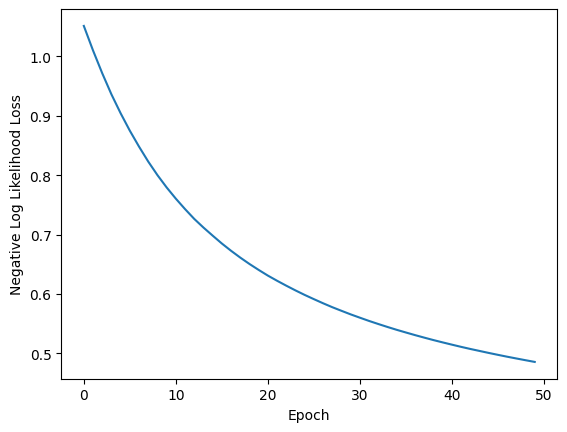

In [12]:
plt.plot(loss)
plt.ylabel('Negative Log Likelihood Loss')
plt.xlabel('Epoch')
plt.show()

In [13]:
from matplotlib.colors import ListedColormap
import numpy as np


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    logits = classifier.forward(tensor)
    probas=F.softmax(logits,dim=1)
    Z = np.argmax(probas.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx],
                    label=cl)

<ipython-input-13-fb464afffa71>:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
<ipython-input-13-fb464afffa71>:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(x2_min, x2_max, resolution))
<ipython-input-13-fb464afffa71>:29: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


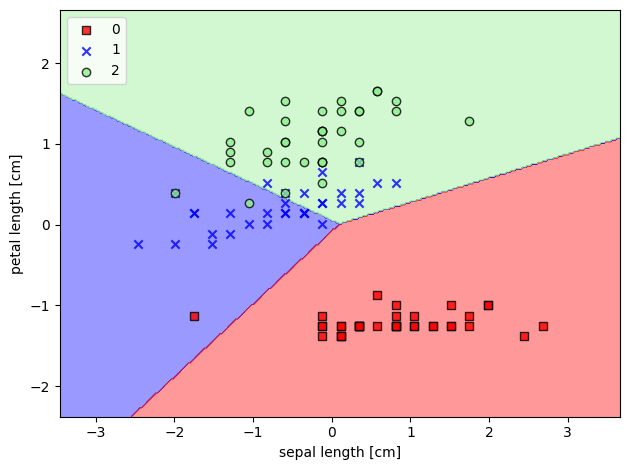

In [14]:
plot_decision_regions(X_train, y_train, classifier=softmax_regr01)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### 2. Softmax Regression Automated











In [15]:
class SoftmaxRegression02(torch.nn.Module):
  def __init__(self,num_features,num_classes):
    super().__init__()
    self.linear=torch.nn.Linear(num_features,num_classes)
    self.linear.weight.detach().zero_()
    self.linear.bias.detach().zero_()

  def forward(self,X):
    logits=self.linear(X)
    return logits

  def train(self,X,y,num_epochs,lr=0.01,batch_size=10):
    loss_arr=[]

    torch.manual_seed(123)

    optimizer = torch.optim.SGD(self.parameters(), lr=lr)

    shuffle_idx=torch.randperm(X.shape[0])

    X=X[shuffle_idx]
    y=y[shuffle_idx]

    batch_indices=torch.split(shuffle_idx,batch_size)
    for epoch in range(num_epochs):
      for batch_idx in batch_indices:
        y_hat=self.forward(X[batch_idx])
        loss=F.cross_entropy(y_hat,y[batch_idx].type(torch.int64))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      with torch.no_grad():
        y_preds=self.forward(X)
        epoch_loss=F.cross_entropy(y_preds,y.type(torch.int64))

        print(f"Epoch {epoch} loss {epoch_loss}")
        loss_arr.append(epoch_loss)
    return loss_arr




In [16]:
softmax_regr02=SoftmaxRegression02(num_features=X.shape[1],num_classes=len(torch.unique(y_train)))
loss02=softmax_regr02.train(X_train,y_train,50)

Epoch 0 loss 1.0514488220214844
Epoch 1 loss 1.0085920095443726
Epoch 2 loss 0.9696667790412903
Epoch 3 loss 0.9343041777610779
Epoch 4 loss 0.9021508097648621
Epoch 5 loss 0.8728760480880737
Epoch 6 loss 0.8461751937866211
Epoch 7 loss 0.821772038936615
Epoch 8 loss 0.799418032169342
Epoch 9 loss 0.778892457485199
Epoch 10 loss 0.7599990963935852
Epoch 11 loss 0.7425650954246521
Epoch 12 loss 0.7264383435249329
Epoch 13 loss 0.7114842534065247
Epoch 14 loss 0.6975851655006409
Epoch 15 loss 0.6846370100975037
Epoch 16 loss 0.6725479364395142
Epoch 17 loss 0.6612370014190674
Epoch 18 loss 0.6506325602531433
Epoch 19 loss 0.6406710743904114
Epoch 20 loss 0.6312959790229797
Epoch 21 loss 0.6224568486213684
Epoch 22 loss 0.6141089200973511
Epoch 23 loss 0.6062119007110596
Epoch 24 loss 0.59872967004776
Epoch 25 loss 0.5916296243667603
Epoch 26 loss 0.5848828554153442
Epoch 27 loss 0.5784627199172974
Epoch 28 loss 0.5723453164100647
Epoch 29 loss 0.5665090680122375
Epoch 30 loss 0.560934185

In [17]:
print('\nModel parameters:')
print('  Weights: %s' % softmax_regr02.linear.weight)
print('  Bias: %s' % softmax_regr02.linear.bias)


Model parameters:
  Weights: Parameter containing:
tensor([[ 0.5768, -1.0807],
        [-0.4910,  0.0747],
        [-0.0858,  1.0059]], requires_grad=True)
  Bias: Parameter containing:
tensor([-0.0404,  0.0280,  0.0123], requires_grad=True)


In [18]:
y_preds02=softmax_regr02.forward(X_test)
y_preds02=torch.argmax(y_preds02,dim=1)
accuracy=torch.sum(y_preds02==y_test)/len(y_preds02)
print(f"Accuracy {accuracy*100}")

Accuracy 86.66666412353516


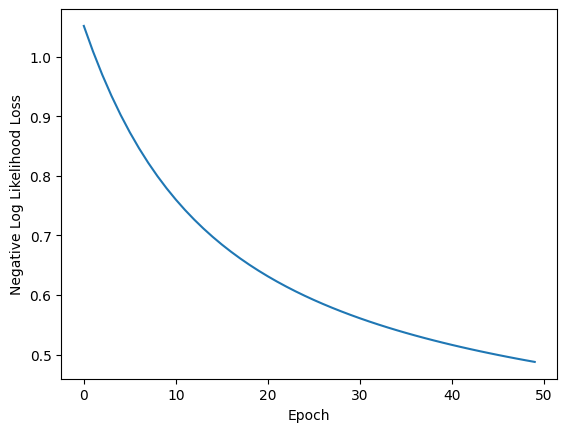

In [19]:
plt.plot(loss02)
plt.ylabel('Negative Log Likelihood Loss')
plt.xlabel('Epoch')
plt.show()

<ipython-input-13-fb464afffa71>:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
<ipython-input-13-fb464afffa71>:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(x2_min, x2_max, resolution))
<ipython-input-13-fb464afffa71>:29: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


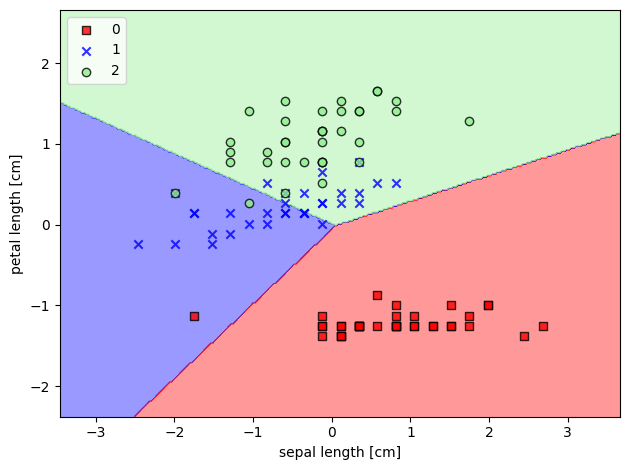

In [20]:
plot_decision_regions(X_train, y_train, classifier=softmax_regr02)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()